In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image
import os
import pathlib
import numpy as np
import pathlib
import shutil

In [0]:
BASE_PATH = '/dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331'
DATA_PATH = '/dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/Pictures'

checkpoint_path = BASE_PATH + "/Model/Best_Model_V2.h5py"
checkpoint_dir = os.path.dirname(checkpoint_path)
# train_dir = pathlib.Path(DATA_PATH+'/training')
# val_dir = pathlib.Path(DATA_PATH+'/val')

# train_dir = dbutils.fs.ls(DATA_PATH+"/train/")
# val_dir = dbutils.fs.ls(DATA_PATH+"/val/")
batch_size = 128
img_height = 120
img_width = 160

resized_height = 120
resized_width = 160

# IMG_SHAPE = (224, 224, 3)
# CLASS_PEOPLE = "/dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/training/people_class"
num_classes = 2
NUM_EPOCHS = 50
seed = 12
log_dir = BASE_PATH + "/logs"

STEPS_PER_EPOCH = 1508 //batch_size

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
#   layers.experimental.preprocessing.RandomContrast(0.2),
])

resize = tf.keras.layers.experimental.preprocessing.Resizing(resized_height, resized_width)

def preprocess_input(image):
    return (image/127.5) - 1

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  seed=seed,
  shuffle=True,
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width)
)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

train_ds = train_ds.map(
  lambda x, y: (preprocess_input(x), y))


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  seed=seed,
  shuffle=True,
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width)
)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(
  lambda x, y: (preprocess_input(x), y))

Found 11163 files belonging to 2 classes.
Using 8931 files for training.
Found 11163 files belonging to 2 classes.
Using 2232 files for validation.

In [0]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (10, 0.005),
    (30, 0.001),
    (50, 0.0005)
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [0]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, GlobalAveragePooling2D,Input
from tensorflow.keras.layers import Activation, BatchNormalization, Add, Multiply, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


def MobileNetV2(alpha=0.35):
  base_model = tf.keras.applications.MobileNetV2(
      input_shape=(img_height, img_width, 3),
      include_top=False, weights='imagenet', alpha=alpha)
#     base_model.trainable = False
  base_model.trainable = True
  x = base_model.output
  # Add a new classifier layer for transfer learning
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
  #     prediction_layer = tf.keras.layers.Dense(1, activation='softmax')
  model = tf.keras.Model(inputs=base_model.inputs, outputs=x)
  return model

MobileNetV2().summary

WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
Out[6]: <bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f15030e0670>>

In [0]:
def training_1(alpha=0.35, lr=0.01):
  model = MobileNetV2()

  model.compile(
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

def training_2(alpha=0.35, lr=0.001):
  model = MobileNetV2()

  model.compile(
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

def training_3(alpha=0.35, lr=0.0001):
  model = MobileNetV2()

  model.compile(
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model


def training_4(alpha=0.35, lr=0.00001):
  model = MobileNetV2()

  model.compile(
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

def training_5(alpha=0.35, lr=0.000001):
  model = MobileNetV2()

  model.compile(
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [0]:
NUM_EPOCHS = 50

# call backs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                               save_weights_only= True,
                                               save_best_only = True,
                                               monitor='accuracy',
                                               mode='auto', 
                                               save_freq='epoch',
                                               verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

In [0]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
      print('yes')
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
yes
yes
2 Physical GPUs, 2 Logical GPUs

In [0]:
tf.debugging.set_log_device_placement(True)
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  Model = training_1()
  hist = Model.fit(train_ds,
                   epochs = NUM_EPOCHS,
                    validation_data=val_ds,
                    verbose=2,
                   callbacks=[cp_callback, early_stop]
             )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
280/280 - 360s - loss: 0.4873 - accuracy: 0.7812 - val_loss: 2.8229 - val_accuracy: 0.5246

Epoch 00001: accuracy improved from -inf to 0.78121, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 2/50
280/280 - 38s - loss: 0.2493 - accuracy: 0.9011 - val_loss: 2.6730 - val_accuracy: 0.5596

Epoch 00002: accuracy improved from 0.78121 to 0.90113, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 3/50
280/280 - 37s - loss: 0.1885 - accuracy: 0.9304 - val_loss: 4.0078 - val_accuracy: 0.5466

Epoch 00003: accuracy improved from 0.90113 to 0.93035, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 4/50
280/280 - 36s - loss: 0.1557 - accuracy: 0.9438 - val_loss: 1.3414 - val_accuracy: 0.5260

Epoch 00004: accuracy improved from 0.93035 to 0.94379, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 5/50
280/280 - 36s - loss: 0.1379 - accuracy: 0.9520 - val_loss: 2.6190 - val_accuracy: 0.5672

Epoch 00005: accuracy improved from 0.94379 to 0.95197, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 6/50
280/280 - 35s - loss: 0.1255 - accuracy: 0.9585 - val_loss: 2.7012 - val_accuracy: 0.5251

Epoch 00006: accuracy improved from 0.95197 to 0.95846, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 7/50
280/280 - 36s - loss: 0.1129 - accuracy: 0.9627 - val_loss: 1.3354 - val_accuracy: 0.5650

Epoch 00007: accuracy improved from 0.95846 to 0.96271, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 8/50
280/280 - 36s - loss: 0.1032 - accuracy: 0.9642 - val_loss: 2.0845 - val_accuracy: 0.5520

Epoch 00008: accuracy improved from 0.96271 to 0.96417, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 9/50
280/280 - 35s - loss: 0.1034 - accuracy: 0.9636 - val_loss: 1.8

In [0]:
with strategy.scope():
  Model = training_2()
  Model.load_weights(checkpoint_path)
  hist = Model.fit(train_ds,
                   epochs = NUM_EPOCHS,
                    validation_data=val_ds,
                    verbose=2,
                   callbacks=[cp_callback, early_stop]
             )

WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
280/280 - 72s - loss: 0.0386 - accuracy: 0.9859 - val_loss: 0.1001 - val_accuracy: 0.9709

Epoch 00001: accuracy did not improve from 0.98813
Epoch 2/50
280/280 - 36s - loss: 0.0417 - accuracy: 0.9848 - val_loss: 0.0826 - val_accuracy: 0.9754

Epoch 00002: accuracy did not improve from 0.98813
Epoch 3/50
280/280 - 35s - loss: 0.0375 - accuracy: 0.9868 - val_loss: 1.3963 - val_accuracy: 0.7070

Epoch 00003: accuracy did not improve from 0.98813
Epoch 4/50
280/280 - 34s - loss: 0.0378 - accuracy: 0.9866 - val_loss: 0.1717 - val_accuracy: 0.9633

Epoch 00004: accuracy did not improve from 0.98813
Epoch 5/50
280/280 - 36s - loss: 0.0385 - accuracy: 0.9858 - val_loss: 0.5532 - val_accuracy: 0.8499

Epoch 00005: accuracy did not improve from 0.98813
Epoch 6/50
280/280 - 35s - loss: 0.0406 - accuracy: 0.9870 - val_loss: 0.0843 - val_accuracy: 0.9709

Epoch 00006: accuracy did not improve from 0.98813
Epoch 7/50
280/280 - 34s - loss: 0.0386 - accuracy: 0.9871 - val_loss: 0.1112 - val_accuracy: 0.9642

Epoch 00007: accuracy did not improve from 0.98813
Epoch 8/50
280/280 - 34s - loss: 0.0396 - accuracy: 0.9871 - val_loss: 0.0963 - val_accuracy: 0.9736

Epoch 00008: accuracy did not improve from 0.98813
Epoch 9/50
280/280 - 35s - loss: 0.0369 - accuracy: 0.9856 - val_loss: 0.0913 - val_accuracy: 0.9727

Epoch 00009: accuracy did not improve from 0.98813
Epoch 10/50
280/280 - 35s - loss: 0.0378 - accuracy: 0.9877 - val_loss: 0.1142 - val_accuracy: 0.9530

Epoch 00010: accuracy did not improve from 0.98813
Epoch 11/50
280/280 - 36s - loss: 0.0371 - accuracy: 0.9876 - val_loss: 0.0692 - val_accuracy: 0.9776

Epoch 00011: accuracy did not improve from 0.98813
Epoch 12/50
280/280 - 35s - loss: 0.0299 - accuracy: 0.9890 - val_loss: 0.0952 - val_accuracy: 0.9646

Epoch 00012: accuracy improved from 0.98813 to 0.98903, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 13/50
280/280 - 35s - loss: 0.0305 - accuracy: 0.9891 - val_loss: 0.0926 - val_accuracy: 0.9758

Epoch 00013: accuracy improved from 0.98903 to 0.98914, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 14/50
280/280 - 36s - loss: 0.0353 - accuracy: 0.9872 - val_loss: 0.2752 - val_accuracy: 0.9337

Epoch 00014: accuracy did not improve from 0.98914
Epoch 15/50
280/280 - 34s - loss: 0.0388 - accuracy: 0.9843 - val_loss: 0.5574 - val_accuracy: 0.9077

Epoch 00015: accuracy did not improve from 0.98914
Epoch 16/50
280/280 - 36s - loss: 0.0344 - accuracy: 0.9866 - val_loss: 0.0942 - val_accuracy: 0.9686

Epoch 00016: accuracy did not improve from 0.98914
Epoch 17/50
280/280 - 35s - loss: 0.0293 - accuracy: 0.9888 - val_loss: 0.1104 - val_accuracy: 0.9664

Epoch 00017: accuracy did not improve from 0.98914
Epoch 18/50
280/280 - 36s - loss: 0.0322 - accuracy: 0.9880 - val_loss: 0.0711 - val_accuracy: 0.9812

Epoch 00018: accuracy did not improve from 0.98914
Epoch 19/50
280/280 - 36s - loss: 0.0309 - accuracy: 0.9888 - val_loss: 0.1089 - val_accuracy: 0.9709

Epoch 00019: accuracy did not improve from 0.98914
Epoch 20/50
280/280 - 34s - loss: 0.0380 - accuracy: 0.9862 - val_loss: 0.3700 - val_accuracy: 0.9306

Epoch 00020: accuracy did not improve from 0.98914
Epoch 21/50
280/280 - 34s - loss: 0.0337 - accuracy: 0.9872 - val_loss: 0.1197 - val_accuracy: 0.9727

Epoch 00021: accuracy did not improve from 0.98914
Epoch 22/50
280/280 - 36s - loss: 0.0297 - accuracy: 0.9887 - val_loss: 0.0764 - val_accuracy: 0.9789

Epoch 00022: accuracy did not improve from 0.98914
Epoch 23/50
280/280 - 35s - loss: 0.0327 - accuracy: 0.9876 - val_loss: 

In [0]:
with strategy.scope():
  Model = training_3()
  Model.load_weights(checkpoint_path)
  hist = Model.fit(train_ds,
                   epochs = NUM_EPOCHS,
                    validation_data=val_ds,
                    verbose=2,
                   callbacks=[cp_callback, early_stop]
             )

WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
280/280 - 69s - loss: 0.0359 - accuracy: 0.9869 - val_loss: 0.0852 - val_accuracy: 0.9754

Epoch 00001: accuracy did not improve from 0.98914
Epoch 2/50
280/280 - 34s - loss: 0.0319 - accuracy: 0.9869 - val_loss: 0.1701 - val_accuracy: 0.9507

Epoch 00002: accuracy did not improve from 0.98914
Epoch 3/50
280/280 - 36s - loss: 0.0354 - accuracy: 0.9870 - val_loss: 0.0927 - val_accuracy: 0.9776

Epoch 00003: accuracy did not improve from 0.98914
Epoch 4/50
280/280 - 35s - loss: 0.0286 - accuracy: 0.9896 - val_loss: 0.1168 - val_accuracy: 0.9682

Epoch 00004: accuracy improved from 0.98914 to 0.98959, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 5/50
280/280 - 36s - loss: 0.0322 - accuracy: 0.9890 - val_loss: 0.2340 - val_accuracy: 0.9359

Epoch 00005: accuracy did not improve from 0.98959
Epoch 6/50
280/280 - 34s - loss: 0.0323 - accuracy: 0.9888 - val_loss: 0.1708 - val_accuracy: 0.9467

Epoch 00006: accuracy did not improve from 0.98959
Epoch 7/50
280/280 - 35s - loss: 0.0306 - accuracy: 0.9900 - val_loss: 0.2148 - val_accuracy: 0.9453

Epoch 00007: accuracy improved from 0.98959 to 0.99003, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 8/50
280/280 - 35s - loss: 0.0335 - accuracy: 0.9867 - val_loss: 0.1605 - val_accuracy: 0.9386

Epoch 00008: accuracy did not improve from 0.99003
Epoch 9/50
280/280 - 35s - loss: 0.0280 - accuracy: 0.9894 - val_loss: 0.0966 - val_accuracy: 0.9709

Epoch 00009: accuracy did not improve from 0.99003
Epoch 10/50
280/280 - 36s - loss: 0.0301 - accuracy: 0.9887 - val_loss: 0.1223 - val_accuracy: 0.9655

Epoch 00010: accuracy did not improve from 0.99003
Epoch 11/50
280/280 - 35s - loss: 0.0285 - accuracy: 0.9897 - val_loss: 0.0938 - val_accuracy: 0.9659

Epoch 00011: accuracy did not improve from 0.99003
Epoch 12/50
280/280 - 34s - loss: 0.0334 - accuracy: 0.9886 - val_loss: 0.0893 - val_accuracy: 0.9718

Epoch 00012: accuracy did not improve from 0.99003
Epoch 13/50
280/280 - 36s - loss: 0.0385 - accuracy: 0.9854 - val_loss: 0.0854 - val_accuracy: 0.9789

Epoch 00013: accuracy did not improve from 0.99003
Epoch 14/50
280/280 - 35s - loss: 0.0278 - accuracy: 0.9900 - val_loss: 0.0989 - val_accuracy: 0.9686

Epoch 00014: accuracy did not improve from 0.99003
Epoch 15/50
280/280 - 36s - loss: 0.0249 - accuracy: 0.9909 - val_loss: 0.0740 - val_accuracy: 0.9812

Epoch 00015: accuracy improved from 0.99003 to 0.99093, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 16/50
280/280 - 35s - loss: 0.0243 - accuracy: 0.9908 - val_loss: 0.1515 - val_accuracy: 0.9682

Epoch 00016: accuracy did not improve from 0.99093
Epoch 17/50
280/280 - 34s - loss: 0.0321 - accuracy: 0.9870 - val_loss: 0.0989 - val_accuracy: 0.9763

Epoch 00017: accuracy did not improve from 0.99093
Epoch 18/50
280/280 - 35s - loss: 0.0331 - accuracy: 0.9884 - val_loss: 0.0813 - val_accuracy: 0.9798

Epoch 00018: accuracy did not improve from 0.99093
Epoch 19/50
280/280 - 34s - loss: 0.0250 - accuracy: 0.9901 - val_loss: 0.0938 - val_accuracy: 0.9767

Epoch 00019: accuracy did not improve from 0.99093
Epoch 20/50
280/280 - 36s - loss: 0.0302 - accuracy: 0.9882 - val_loss: 0.1840 - val_accuracy: 0.9297

Epoch 00020: accuracy did not improve from 0.99093
Epoch 21/50
280/280 - 35s - loss: 0.0311 - accuracy: 0.9888 - val_loss: 0.1051 - val_accuracy: 0.9727

Epoch 00021: accuracy did not improve from 0.99093
Epoch 22/50
280/280 - 35s - loss: 0.0327 - accuracy: 0.9888 - val_loss: 0.1288 - val_accuracy: 0.9601

Epoch 00022: accuracy 

In [0]:
with strategy.scope():
  Model = training_4()
  Model.load_weights(checkpoint_path)
  hist = Model.fit(train_ds,
                   epochs = NUM_EPOCHS,
                    validation_data=val_ds,
                    verbose=2,
                   callbacks=[cp_callback, early_stop]
             )

WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
280/280 - 72s - loss: 0.0278 - accuracy: 0.9896 - val_loss: 0.1073 - val_accuracy: 0.9659

Epoch 00001: accuracy did not improve from 0.99093
Epoch 2/50
280/280 - 36s - loss: 0.0353 - accuracy: 0.9858 - val_loss: 0.1320 - val_accuracy: 0.9664

Epoch 00002: accuracy did not improve from 0.99093
Epoch 3/50
280/280 - 36s - loss: 0.0251 - accuracy: 0.9886 - val_loss: 0.1011 - val_accuracy: 0.9722

Epoch 00003: accuracy did not improve from 0.99093
Epoch 4/50
280/280 - 36s - loss: 0.0289 - accuracy: 0.9887 - val_loss: 0.1319 - val_accuracy: 0.9709

Epoch 00004: accuracy did not improve from 0.99093
Epoch 5/50
280/280 - 34s - loss: 0.0260 - accuracy: 0.9918 - val_loss: 0.1132 - val_accuracy: 0.9651

Epoch 00005: accuracy improved from 0.99093 to 0.99183, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 6/50
280/280 - 36s - loss: 0.0297 - accuracy: 0.9896 - val_loss: 0.1696 - val_accuracy: 0.9642

Epoch 00006: accuracy did not improve from 0.99183
Epoch 7/50
280/280 - 35s - loss: 0.0317 - accuracy: 0.9878 - val_loss: 0.1178 - val_accuracy: 0.9754

Epoch 00007: accuracy did not improve from 0.99183
Epoch 8/50
280/280 - 34s - loss: 0.0278 - accuracy: 0.9889 - val_loss: 0.0829 - val_accuracy: 0.9785

Epoch 00008: accuracy did not improve from 0.99183
Epoch 9/50
280/280 - 36s - loss: 0.0238 - accuracy: 0.9912 - val_loss: 0.1520 - val_accuracy: 0.9494

Epoch 00009: accuracy did not improve from 0.99183
Epoch 10/50
280/280 - 35s - loss: 0.0302 - accuracy: 0.9891 - val_loss: 0.1174 - val_accuracy: 0.9727

Epoch 00010: accuracy did not improve from 0.99183
Epoch 11/50
280/280 - 35s - loss: 0.0271 - accuracy: 0.9899 - val_loss: 0.1056 - val_accuracy: 0.9695

Epoch 00011: accuracy did not improve from 0.99183
Epoch 12/50
280/280 - 35s - loss: 0.0257 - accuracy: 0.9897 - val_loss: 0.1038 - val_accuracy: 0.9722

Epoch 00012: accuracy did not improve from 0.99183
Epoch 13/50
280/280 - 36s - loss: 0.0306 - accuracy: 0.9886 - val_loss: 0.1364 - val_accuracy: 0.9583

Epoch 00013: accuracy did not improve from 0.99183
Epoch 14/50
280/280 - 35s - loss: 0.0289 - accuracy: 0.9893 - val_loss: 0.0693 - val_accuracy: 0.9816

Epoch 00014: accuracy did not improve from 0.99183
Epoch 15/50
280/280 - 36s - loss: 0.0235 - accuracy: 0.9915 - val_loss: 0.0941 - val_accuracy: 0.9758

Epoch 00015: accuracy did not improve from 0.99183

In [0]:
with strategy.scope():
  Model = training_5()
  Model.load_weights(checkpoint_path)
  hist = Model.fit(train_ds,
                   epochs = NUM_EPOCHS,
                    validation_data=val_ds,
                    verbose=2,
                   callbacks=[cp_callback, early_stop]
             )

WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
280/280 - 70s - loss: 0.0315 - accuracy: 0.9886 - val_loss: 0.0757 - val_accuracy: 0.9754

Epoch 00001: accuracy did not improve from 0.99183
Epoch 2/50
280/280 - 34s - loss: 0.0265 - accuracy: 0.9897 - val_loss: 0.0542 - val_accuracy: 0.9803

Epoch 00002: accuracy did not improve from 0.99183
Epoch 3/50
280/280 - 36s - loss: 0.0279 - accuracy: 0.9890 - val_loss: 0.0900 - val_accuracy: 0.9736

Epoch 00003: accuracy did not improve from 0.99183
Epoch 4/50
280/280 - 35s - loss: 0.0335 - accuracy: 0.9880 - val_loss: 0.0926 - val_accuracy: 0.9736

Epoch 00004: accuracy did not improve from 0.99183
Epoch 5/50
280/280 - 36s - loss: 0.0260 - accuracy: 0.9905 - val_loss: 0.1306 - val_accuracy: 0.9664

Epoch 00005: accuracy did not improve from 0.99183
Epoch 6/50
280/280 - 35s - loss: 0.0236 - accuracy: 0.9903 - val_loss: 0.1112 - val_accuracy: 0.9763

Epoch 00006: accuracy did not improve from 0.99183
Epoch 7/50
280/280 - 35s - loss: 0.0243 - accuracy: 0.9907 - val_loss: 0.0970 - val_accuracy: 0.9745

Epoch 00007: accuracy did not improve from 0.99183
Epoch 8/50
280/280 - 36s - loss: 0.0299 - accuracy: 0.9893 - val_loss: 0.0895 - val_accuracy: 0.9807

Epoch 00008: accuracy did not improve from 0.99183
Epoch 9/50
280/280 - 35s - loss: 0.0292 - accuracy: 0.9899 - val_loss: 0.1981 - val_accuracy: 0.9610

Epoch 00009: accuracy did not improve from 0.99183
Epoch 10/50
280/280 - 36s - loss: 0.0270 - accuracy: 0.9899 - val_loss: 0.1433 - val_accuracy: 0.9467

Epoch 00010: accuracy did not improve from 0.99183
Epoch 11/50
280/280 - 36s - loss: 0.0296 - accuracy: 0.9887 - val_loss: 0.1715 - val_accuracy: 0.9565

Epoch 00011: accuracy did not improve from 0.99183
Epoch 12/50
280/280 - 36s - loss: 0.0237 - accuracy: 0.9913 - val_loss: 0.0787 - val_accuracy: 0.9803

Epoch 00012: accuracy did not improve from 0.99183
Epoch 13/50
280/280 - 36s - loss: 0.0236 - accuracy: 0.9908 - val_loss: 0.0893 - val_accuracy: 0.9772

Epoch 00013: accuracy did not improve from 0.99183
Epoch 14/50
280/280 - 35s - loss: 0.0250 - accuracy: 0.9914 - val_loss: 0.0857 - val_accuracy: 0.9727

Epoch 00014: accuracy did not improve from 0.99183
Epoch 15/50
280/280 - 36s - loss: 0.0216 - accuracy: 0.9927 - val_loss: 0.1270 - val_accuracy: 0.9642

Epoch 00015: accuracy improved from 0.99183 to 0.99272, saving model to /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py
Epoch 16/50
280/280 - 35s - loss: 0.0194 - accuracy: 0.9921 - val_loss: 0.0966 - val_accuracy: 0.9740

Epoch 00016: accuracy did not improve from 0.99272
Epoch 17/50
280/280 - 35s - loss: 0.0253 - accuracy: 0.9912 - val_loss: 0.0801 - val_accuracy: 0.9731

Epoch 00017: accuracy did not improve from 0.99272
Epoch 18/50
280/280 - 36s - loss: 0.0211 - accuracy: 0.9919 - val_loss: 0.0766 - val_accuracy: 0.9780

Epoch 00018: accuracy did not improve from 0.99272
Epoch 19/50
280/280 - 35s - loss: 0.0236 - accuracy: 0.9917 - val_loss: 0.1313 - val_accuracy: 0.9610

Epoch 00019: accuracy did not improve from 0.99272
Epoch 20/50
280/280 - 36s - loss: 0.0221 - accuracy: 0.9907 - val_loss: 0.0750 - val_accuracy: 0.9789

Epoch 00020: accuracy did not improve from 0.99272
Epoch 21/50
280/280 - 34s - loss: 0.0232 - accuracy: 0.9910 - val_loss: 0.0717 - val_accuracy: 0.9794

Epoch 00021: accuracy did not improve from 0.99272
Epoch 22/50
280/280 - 36s - loss: 0.0241 - accuracy: 0.9927 - val_loss: 0.2465 - val_accuracy: 0.9431

Epoch 00022: accuracy did not improve from 0.99272
Epoch 23/50
280/280 - 36s - loss: 0.0246 - accuracy: 0.9897 - val_loss: 0.2199 - val_accuracy: 0.9530

Epoch 00023: accuracy did not improve from 0.99272
Epoch 24/50
280/280

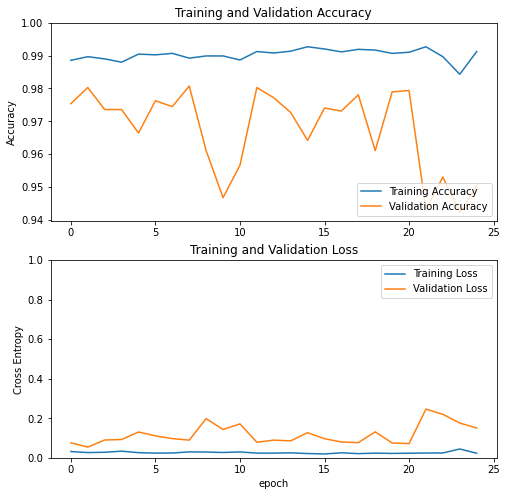

In [0]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
Model = training_5()
Model.load_weights(checkpoint_path)
Model.save(checkpoint_path)

WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
INFO:tensorflow:Assets written to: /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0331/Model/Best_Model_V2.h5py/assets

Python interpreter will be restarted.
Collecting pydot
 Downloading pydot-1.4.2-py2.py3-none-any.whl (21 kB)
Requirement already satisfied: pyparsing>=2.1.4 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-cf2b5fdd-149b-4ff1-9473-560eb70769a7/lib/python3.8/site-packages (from pydot) (2.4.7)
Installing collected packages: pydot
Successfully installed pydot-1.4.2
Python interpreter will be restarted.